# Fig 2

Monogenic resistance can give low doses better sometimes

Heatmaps

Data comes from cluster run (see `cluster/fig2.py` and other related files in `cluster`)

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [68]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

from xgboost import XGBRegressor
import shap
import itertools

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_explicit,
    get_corner_annotations_custom_labels,
    get_dose_colors
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist, Fungicide
from poly2.run import get_data_from_pars
from poly2.config import Config

In [3]:
sns.set_palette("viridis_r", n_colors=10)

# Get data

In [4]:
df = pd.read_csv('../outputs/combined/fig2/fig2.csv')

df.head()

,year,s,r,yld,dose
0,1,0.005,0.015,10.504639,1.0
1,1,0.005,0.025,10.504620,1.0
2,1,0.005,0.035,10.504604,1.0
3,1,0.005,0.045,10.504589,1.0
4,1,0.005,0.055,10.504574,1.0


In [5]:
df.describe()

,year,s,r,yld,dose
count,99000.00000,99000.000000,99000.000000,99000.000000,99000.000000
mean,10.50000,0.331667,0.668333,9.706433,0.850126
std,5.76631,0.234498,0.234498,0.388214,0.282279
min,1.00000,0.005000,0.015000,8.820845,0.100000
25%,5.75000,0.135000,0.505000,9.382368,0.900000
50%,10.50000,0.295000,0.705000,9.693821,1.000000
75%,15.25000,0.495000,0.865000,10.021215,1.000000
max,20.00000,0.985000,0.995000,10.504639,1.000000


In [6]:
df.loc[lambda x: x.year==20].groupby(['r', 's']).apply(lambda x: x.loc[x.yld.idxmax(), ['dose']]).unstack(level=-1)

dose                                                        ...        \
s     0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095  ... 0.895   
r                                                                  ...         
0.015   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
0.025   1.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
0.035   1.0   1.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
0.045   1.0   1.0   1.0   1.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
0.055   1.0   1.0   1.0   1.0   1.0   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
0.955   1.0   1.0   1.0   1.0   1.0   1.0   0.1   0.1   0.1   0.1  ...   1.0   
0.965   1.0   1.0   1.0   1.0   1.0   0.1   0.1   0.1   0.1   0.1  ...   1.0   
0.975   1.0   1.0   1.0   1.0   0.1   0.1   0.1   0.1   0.1   0.1  ...   1.0   
0.985   1.0   1.0   1.0   1.0   0.1   0.1   0.1   0.1   0.1   0.1  ...   1.0   
0.995   1.0   1.0   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1  ...   1.0   

                                                             
s     0.905 0.915 0.925 0.935 0.945 0.955 0.965 0.975 0.985  
r                                                            
0.015   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.025   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.035   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.045   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.055   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
0.955   1.0   1.0   1.0   1.0   1.0   NaN   NaN   NaN   NaN  
0.965   1.0   1.0   1.0   1.0   1.0   1.0   NaN   NaN   NaN  
0.975   1.0   1.0   1.0   1.0   1.0   1.0   1.0   NaN   NaN  
0.985   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   NaN  
0.995   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  

[99 rows x 99 columns]

In [7]:
def get_df(year):
    out = (
        df
        .loc[lambda x: x.year==year]
        .groupby(['r', 's'])
        .apply(lambda x: x.loc[x.yld.idxmax(), ['dose']])
        .unstack(level=-1)
    )

    out.columns = df.s.unique()

    return out

In [8]:
dA = get_df(1)
dB = get_df(5)
dC = get_df(10)
dD = get_df(15)
dE = get_df(20)

In [9]:
df.loc[lambda x: x.year.isin([1,5,10,15,20])].describe().loc[['min', 'max']]

,year,s,r,yld,dose
min,1.0,0.005,0.015,8.820845,0.1
max,20.0,0.985,0.995,10.504639,1.0


In [10]:
ever_full_dose = (
    df
    .groupby(['r', 's', 'year'])
    .apply(lambda x: x.loc[x.yld.idxmax(), ['dose']])
    .reset_index()
    .groupby(['r', 's'])
    .min()
    .assign(not_full_dose = lambda x: x.dose<1)
    .loc[:, ['not_full_dose']]
    .unstack(level=-1)
)

In [11]:
ever_full_dose.head()

not_full_dose                                                            \
s             0.005  0.015  0.025  0.035  0.045 0.055 0.065 0.075 0.085 0.095   
r                                                                               
0.015         False    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
0.025         False  False    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
0.035         False  False  False    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
0.045         False  False  False  False    NaN   NaN   NaN   NaN   NaN   NaN   
0.055         False  False  False  False  False   NaN   NaN   NaN   NaN   NaN   

       ...                                                              
s      ... 0.895 0.905 0.915 0.925 0.935 0.945 0.955 0.965 0.975 0.985  
r      ...                                                              
0.015  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.025  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.035  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.045  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
0.055  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 99 columns]

In [12]:
ever_full_dose_use = ever_full_dose.astype('float64')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


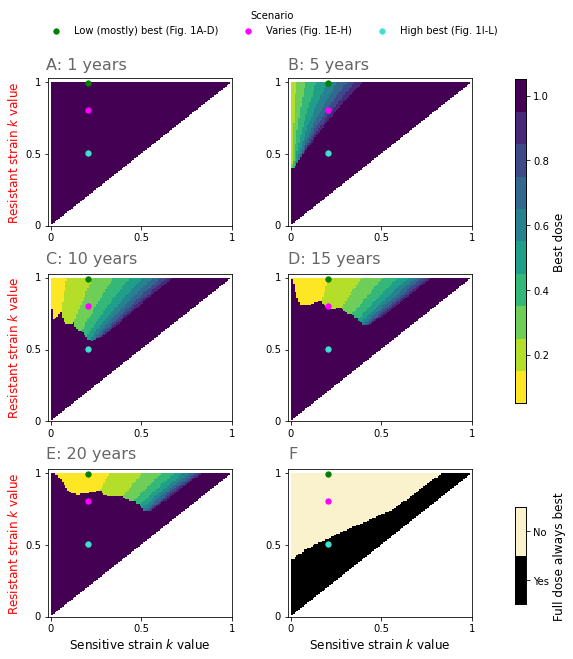

In [69]:
f, ax = plt.subplots(
    3,
    2, 
    figsize=(8,9),
)

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

vmin=0.05
vmax=1.05

cmap = get_dose_colors()



cax = plt.axes([0.9, 0.4, 0.02, 0.5])
cax2 = plt.axes([0.9, 0.09, 0.02, 0.15])


cbar_label = 'Best dose'
cbar_label2 = 'Full dose always best'



colors2 = ['k', (0.98, 0.95, 0.8)]
cmap2 = ListedColormap(colors2)



sns.heatmap(
    data=dA,
    ax=ax[0][0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_ax=cax,
    cbar_kws=dict(label=cbar_label)
)

sns.heatmap(
    data=dB,
    ax=ax[0][1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)

sns.heatmap(
    data=dC,
    ax=ax[1][0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)

sns.heatmap(
    data=dD,
    ax=ax[1][1],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)


sns.heatmap(
    data=dE,
    ax=ax[2][0],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)

sns.heatmap(
    data=ever_full_dose_use,
    ax=ax[2][1],
    cmap=cmap2,
    cbar=True,
    cbar_ax=cax2,
    cbar_kws=dict(label=cbar_label2, ticks=[0.25, 0.75])
)

cax2.set_yticklabels(['Yes', 'No'])


x1 = 20.5
y1 = 99.5-1

x2 = 20.5
y2 = 80.5-1

x3 = 20.5
y3 = 50.5-1

ss = 28

for ii, jj in itertools.product(np.arange(3), np.arange(2)):
    l1 = 'Low (mostly) best (Fig. 1A-D)' if ii+jj==0 else None
    l2 = 'Varies (Fig. 1E-H)' if ii+jj==0 else None
    l3 = 'High best (Fig. 1I-L)' if ii+jj==0 else None
    
    ax[ii][jj].scatter([x1], [y1], c='green', s=ss, label=l1)
    ax[ii][jj].scatter([x2], [y2], c='magenta', s=ss, label=l2)
    ax[ii][jj].scatter([x3], [y3], c='turquoise', s=ss, label=l3)



ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[0][1].invert_yaxis()
ax[1][1].invert_yaxis()


ax[0][0].set_ylabel(r'Resistant strain $k$ value')
ax[1][0].set_ylabel(r'Resistant strain $k$ value')
ax[2][0].set_ylabel(r'Resistant strain $k$ value')
ax[0][1].set_ylabel(None)
ax[1][1].set_ylabel(None)
ax[2][1].set_ylabel(None)

ax[0][0].set_xlabel(None)
ax[1][0].set_xlabel(None)
ax[2][0].set_xlabel(r'Sensitive strain $k$ value')
ax[0][1].set_xlabel(None)
ax[1][1].set_xlabel(None)
ax[2][1].set_xlabel(r'Sensitive strain $k$ value')


for spine in cax.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

for spine in cax2.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")
    
    
    
    
for ii, jj in itertools.product(np.arange(3), np.arange(2)):
    ax[ii][jj].spines['bottom'].set_visible(True)
    ax[ii][jj].spines['left'].set_visible(True)
    ax[ii][jj].spines['top'].set_visible(True)
    ax[ii][jj].spines['right'].set_visible(True)
    
    ax[ii][jj].set_xticks([0, 50, 100], minor=False)
    ax[ii][jj].set_xticklabels([0, 0.5, 1], rotation=0)

    ax[ii][jj].set_yticks([-1, 49, 99], minor=False)
    ax[ii][jj].set_yticklabels([0, 0.5, 1])

    ax[ii][jj].set_xlim([-1.5, 100]) # 0, 100
    ax[ii][jj].set_ylim([-1, 102]) # -1, 99
    
    if jj==0:
        ax[ii][jj].yaxis.label.set_color('red')
        ax[ii][jj].yaxis.label.set_color('red')

f.patch.set_facecolor('white')

plt.tight_layout(rect=[0,0,0.85,0.92], h_pad=3, w_pad=3)

custom_labs = [
    'A: 1 years',
    'B: 5 years',
    'C: 10 years',
    'D: 15 years',
    'E: 20 years',
    'F',
]

get_corner_annotations_custom_labels(2, 3, 0.08, 0.91, 0.42, 0.3, plt, custom_labs)


f.legend(
    loc='upper left',
    title='Scenario',
    bbox_to_anchor = (0.07,1.02),
    framealpha=0,
    ncol=3
)

## Save

In [70]:
f.savefig('../figures/paper/fig2.jpg', dpi=1200, bbox_inches="tight")